# Устанавливаем все библиотеки

In [140]:
### Installing dependecies
%matplotlib inline
!pip install Box2D  > /dev/null 2>&1
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1          
!apt update > /dev/null 2>&1
!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym-super-mario-bros==7.3.0 > /dev/null 2>&1

### For logger's plots parsing
!sudo python3 -m pip install wheel > /dev/null 2>&1
!sudo python3 -m pip install pandas > /dev/null 2>&1
!sudo python3 -m pip install seaborn > /dev/null 2>&1

# Подключаем библиотеки (все импорты писать сюда)

In [141]:
### Includes libs

import torch
from torch import nn
from torch import optim
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy, itertools

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

# Visualization
from pyvirtualdisplay import Display

# Logging
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time


%matplotlib inline


# Переносим вычисления на GPU

In [142]:
### Connect to GPU
# Устройство, на котором будет работать PyTorch.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # GPU trains faster

if torch.cuda.is_available():
    print("Вы используете gpu, все ок")
else:
    print("Вы не используете gpu!! Если вы в google colab, выберите gpu в Runtime -> Change Runtime type")

Вы используете gpu, все ок


# Инициализируем окружение игры и ограничиваем действия Марио

(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


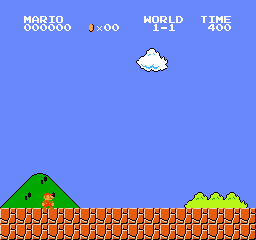

In [143]:
### Create environment
# Инициализация среды
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"], ["right", "A", "B"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

# как сейчас выглядит состояние
Image.fromarray(next_state, "RGB")

# Преобразуем окружение, чтобы нейронка лучше обучалась
- `SkipFrame` - Пропускаем часть фреймов из игры (считываем каждый `skip`-ый фрейм) 
- `GrayScaleObservation` - преобразуем картинку в черно-белую
- `ResizeObservation` - сжимаем изображение shape: `(4, 84, 84)`  

In [144]:
### Transform environment

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor

        # [H, W, C] = [0, 1, 2]
        # [C, H, W] = [2, 0, 1]
        # используйте np.transpose чтобы перевернуть оси в массиве [H, W, C] -> [C, H, W] (H=hight, W=width, C=channels)
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)  # TODO примените метод permute_orientation к observation
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Задаем константы (параметры обучения и прочая дичь)

In [145]:
### constants
# INPUT

STATE_SHAPE = (4, 84, 84) #int(np.prod(env.observation_space.shape)) # 8 #  # dimensions of input image
ACTION_SHAPE = env.action_space.n # number of actions

# TRAINING
TOTAL_EPISODES = 50000
GAMMA = 0.999
LEARNING_RATE = 0.00025
EPS_MAX = 1.0
EPS_MIN = 0.1
EPS_DECAY = 0.50 * TOTAL_EPISODES # eps will become smaller earlier in the learning process
LEARN_FREQ = 3 # after how many steps to learn
LOG_FREQ = 40
PLOT_LOG_FREQ = 1000 

UPDATE_TARGET_FREQ = 200 # hard update target net with online net

# REPLAY BUFFER
BUFFER_SIZE = 100000 # max size of buffer
MIN_BUFFER_SIZE = 1000 # at least put 1000 transitions in a buffer before learning
BATCH_SIZE = 64

# SAVING
SAVE_DIR = Path("saver_surgery") # where checkpoints saved
if not Path('saver_surgery').is_dir():
    SAVE_DIR.mkdir(parents=True)
SAVE_FREQ = 500

# VISUALIZATION
VIDEOS_DIR = Path("videos_surgery") # where checkpoints saved
if not Path('videos_surgery').is_dir():
    VIDEOS_DIR.mkdir(parents=True)

# Визуализация

```
visualize(agent, episodes=1, action_limit=None, fileName=None)
```

`agent` - our Mario

`episodes` - number of videos

`action_limit` - limit of glazed actions

`fileName` - name of the file to upload gif video

In [146]:
### Visualization

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display as ipythondisplay
from IPython.display import HTML

animation.embed_limit = 2**800

In [147]:
def init_figure():
    fig, ax = plt.subplots(figsize=(8, 6), nrows=1, ncols=1)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tight_layout()
    return fig, ax

def show_video(frames, fileName=None):
    fig, ax = init_figure()
    ims = []
    for f in frames:
        im = plt.imshow(f, animated=True)
        ims.append([im])

    # creating animation
    anim = animation.ArtistAnimation(fig, ims, interval = 40, blit=True)
    
    # saving gif file on drive
    if fileName != None:
        writergif = animation.PillowWriter(fps=30) 
        anim.save(fileName, writergif)
        print("Video successfully saved!")
    
    ipythondisplay.display(HTML(anim.to_jshtml()))
    plt.close()

# action_limit == None => non limit
# fileName - name of the file to upload
def visualize(agent, episodes=1, action_limit=None, fileName=None):
    
    bare_env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
    bare_env = JoypadSpace(bare_env, [["right"], ["right", "A"], ["right", "A", "B"]])

    for e in range(episodes):
        frames = []
        
        state = env.reset()
        bare_state = bare_env.reset()
        
        done = False
        cnt = 0
        while not done:
            cnt += 1
            if (action_limit != None) and (cnt > action_limit):
                break
                
            frames.append(Image.fromarray(bare_state, "RGB"))
            
            action = agent.act(state, episode=None, explore=False)
            
            for i in range(4):
                bare_state, _, _done, info = bare_env.step(action)
                
                if _done or info['flag_get']:
                    done = True
                    break
            
            if done: # хз, но это нужно
                break
            
            state, _, done, info = env.step(action)
            
            if info['flag_get']:
                done = True
        
        show_video(frames, fileName)

# Класс нейронки (ее структура прописана тут)
- `model` - поле с инициализированной модель сети
- `forward` - скормливаем сети входные данные
- `get_action` - возвращает действие, на основании значений функции `Q` (Не Epsilon-Greedy!)

In [148]:
class Network(nn.Module):
  def __init__(self):
      super().__init__()
      c, h, w = STATE_SHAPE

      if c != 4:
        raise ValueError(f"Expecting input channels: 4, got: {c}")
      if h != 84:
        raise ValueError(f"Expecting input height: 84, got: {h}")
      if w != 84:
        raise ValueError(f"Expecting input width: 84, got: {w}")

      """
      В нейронной сети нужно начать с конволюционных слоев (CNN) для обработки картинок, после которых идут полносвязные (FC).
      Между слоями функция активации (ReLU).
      Дефолтная архитектура: input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
      Дефолтные параметры:
      CNN1: (in_channels=c, out_channels=32, kernel_size=8, stride=4),
      CNN2: (in_channels=32, out_channels=64, kernel_size=4, stride=2),
      CNN3: (in_channels=64, out_channels=64, kernel_size=3, stride=1)
      Linear 1: (3136, 512)
      Linear 2: (512, out_dim)
      От этой архитектуры можно отклоняться (на свой страх и риск) Сделать поменьше - быстрее обучится. 
      Сделать побольше - потенциально точнее, но времени на это нет.
      Можно попробовать Dropout слой между линейными.
      Можно попробовать добавить l2 регуляризацию - это в оптимизаторе.
      """
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
          nn.ReLU(),

          nn.Flatten(),

          nn.Linear(3136, 512),
          nn.ReLU(),

          nn.Linear(512, ACTION_SHAPE),
      )


  def forward(self, x):
    return self.model(x)

  # selecting an action in Q-learning algorithm
  def get_action(self, state):
    # converting state (obs) to tenser array
    state_t = torch.as_tensor(np.asarray(state), dtype=torch.float32, device=device)
    q_values = self(state_t.unsqueeze(0))

    # getting index of max Q-value
    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item()

    return action

# Класс самого алгоритма DQN
- `online_model` - обучаемая модель 
- `target_model` - вспомогательная модель
- `act` - EpsilonGreedy реализация (запрашиваем жадный `action` у нейронки, либо берем рандомный `action`)
- `compute_loss` - вычисляем `loss`-функцию (`mse` в нашем случаи)
- `learn` - обновляем веса в `online_net` и копируем ее в `target_net`, когда нужно


In [149]:
### DQN ###

class DQN(nn.Module):
    def __init__(self):
        super().__init__()

        # Init online and target net
        self.online_model = Network()
        self.target_model = Network()
        # Update target net
        self.target_model.load_state_dict(self.online_model.state_dict())

        # Transport calculation to GPU
        self.online_model.to(device) 
        self.target_model.to(device)

        self.eps = EPS_MAX
        self.steps = 0 # only for learn function
        
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=LEARNING_RATE)

    def act(self, state, episode, explore=True):
        self.eps = np.interp(episode, [0, EPS_DECAY], [EPS_MAX, EPS_MIN])

        if (explore == True and random.random() < self.eps):
            return random.randint(0, ACTION_SHAPE - 1)
        else:
            return self.online_model.get_action(state)


    # returns loss value 
    def compute_loss(self, batch):
        state, action, next_state, reward, done = batch

        state = torch.as_tensor(np.asarray(state), dtype=torch.float32, device=device)
        next_state = torch.as_tensor(np.asarray(next_state), dtype=torch.float32, device=device)
        reward = torch.as_tensor(np.asarray(reward), dtype=torch.float32, device=device).unsqueeze(-1)
        done = torch.as_tensor(np.asarray(done), dtype=torch.int64, device=device).unsqueeze(-1)
        action = torch.as_tensor(np.asarray(action), dtype=torch.int64, device=device).unsqueeze(-1)

        with torch.no_grad():
            target_q = self.target_model(next_state).max(dim=1, keepdim=True)[0] # batch_size
            target_q = reward + GAMMA * (1 - done) * target_q
        
        q = self.online_model(state)

        q = torch.gather(input=q, dim=1, index=action) # batch_size
        loss = nn.functional.mse_loss(q, target_q)
        return loss

    def learn(self, batch):
        self.steps += 1

        if self.steps % LEARN_FREQ != 0:
            return None

        loss = self.compute_loss(batch)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # HARD UPDATE
        if self.steps % UPDATE_TARGET_FREQ == 0: 
            self.target_model.load_state_dict(self.online_model.state_dict())
        return loss.item()

# ReplayBuffer - Класс буфера реплея


In [150]:
### Replay Buffer ###

class ReplayBuffer:
    def __init__(self, size=BUFFER_SIZE):
        self.data = deque(maxlen=size)
        self.max_size = BUFFER_SIZE
    
    def add(self, transition):
        self.data.append(transition)
        
    def sample(self, size=BATCH_SIZE):
        batch = random.sample(self.data, size)
        return list(zip(*batch))

    def size(self):
        return len(self.data)

    def fill_with_random(self, env):
      state = env.reset()
      for _ in range(MIN_BUFFER_SIZE):
        # getting random action from env
        action = env.action_space.sample()
        # next_obs == next_state, rew == reward
        next_state, reward, done, info = env.step(action)
        # transion that will be added to the replay buffer
        transition = (state, action, next_state, reward, done)
        self.data.append(transition)
        # updating state to a new state (obs -> next_obs)
        state = next_state
        # if the current state is terminal, reset the env 
        if (done):
          state = env.reset()
    
    def fill_with_eps_greedy(self, dqn, episode):
        state = env.reset()
        for _ in range(MIN_BUFFER_SIZE):
            # getting epsilon greedy action
            action = dqn.act(state, episode)
            # next_obs == next_state, rew == reward
            next_state, reward, done, info = env.step(action)
            # transion that will be added to the replay buffer
            transition = (state, action, next_state, reward, done)
            self.data.append(transition)
            # updating state to a new state (obs -> next_obs)
            state = next_state
            # if the current state is terminal, reset the env 
            if (done):
              state = env.reset()

# Logger



```
save_dir = Path("dir") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

logger = MetricLogger(save_dir)
```

`save_dir` - directory to save logging files

`logger.log_step(reward, loss, q)` - logging data inside the class after each step of a model in the `env`

`logger.log_episode()` - (fire after each episode ends) logging data after episode ends

`logger.record(episode, epsilon)` - prints data to the console and logs it to the file named `log` in specified folder, creates plots of `reward`, `loss`, `average of Q-value function`, `duration of episode`



In [151]:
### Metric Logger
from os import path
import csv
import pandas as pd
import seaborn as sns; sns.set()

class MetricLogger:
    def __init__(self, _dir):
        self.save_dir = Path(_dir)
        if not Path(_dir).is_dir():
            self.save_dir.mkdir(parents=True)
        
        self.save_log = self.save_dir / "log.csv"
        
        if (path.isfile(self.save_log) == False):
            headers = ['Episode', 'Epsilon', 'MeanReward', 'MeanLoss', 'TimeDelta', 'Time']
            with open(self.save_log, "a") as f:
                writer = csv.writer(f)
                writer.writerow(headers)

        # History metrics
        self.rewards = []
        self.losses = []
        
        # Timing
        self.record_time = time.time()
        
        # paths to the save_dir folder + file's names
        self.rewards_plot = self.save_dir / "reward_plot.jpg"
        self.losses_plot  = self.save_dir / "loss_plot.jpg"
    
    
    # appends total reward and loss after each episode
    def append(self, reward, loss):
        self.rewards.append(reward)
        self.losses.append(loss)

    # adding data to a file
    def record(self, episode, epsilon):
        mean_reward = np.round(np.mean(self.rewards[-100:]), 3)
        mean_loss = np.round(np.mean(self.losses[-100:]), 3)
        
        # counting time between prev and cur records - time delta
        prev_record_time = self.record_time
        self.record_time  = time.time()
        duration = np.round(self.record_time - prev_record_time, 3)
        
        # printing data
        print(
            f"Episode: {episode}    "
            f"Epsilon: {epsilon}    "
            f"Mean Reward: {mean_reward}    "
            f"Mean Loss: {mean_loss}    "
            f"Time Delta: {duration}    "
            f"Time: {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )
        
        # adding data to a saving file
        with open(self.save_log, "a") as f:
            fields = [episode, epsilon, mean_reward, mean_loss, duration, datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')]
            writer = csv.writer(f)
            writer.writerow(fields)
            
    # plotting
    def create_plots(self):
        df = pd.read_csv(logger.save_log)
        Epsilon_plot = sns.lineplot(x=df.Episode, y=df.Epsilon).get_figure()
        Epsilon_plot.savefig(f"{self.save_dir}/Epsilon_plot.png")
        plt.clf()
        MeanReward_plot = sns.lineplot(x=df.Episode, y=df.MeanReward).get_figure()
        MeanReward_plot.savefig(f"{self.save_dir}/MeanReward_plot.png")
        plt.clf()
        MeanLoss_plot = sns.lineplot(x=df.Episode, y=df.MeanLoss).get_figure()
        MeanLoss_plot.savefig(f"{self.save_dir}/MeanLoss_plot.png")
        plt.clf()
        TimeDelta_plot = sns.lineplot(x=df.Episode, y=df.TimeDelta).get_figure()
        TimeDelta_plot.savefig(f"{self.save_dir}/TimeDelta_plot.png")
        plt.clf()

### Example of logger functionality

In [152]:
# logger = MetricLogger("logger")

# for e in range(1000):
#     done = bool(random.randint(0, 10) % 2)
#     total_reward = 0.0
#     loss_sum = 0.0
#     steps = 0
    
#     mean_loss = 0.0
    
#     while not done:
#         steps          += 1
#         loss_sum       += random.randint(0, 100)
#         total_reward   += random.randint(0, 100)
        
#         if(random.random() > 0.7):
#             done = True
    
#     if(steps != 0):
#         mean_loss = loss_sum / steps
        
#     logger.append(total_reward, mean_loss)
    
#     if(e % 20 == 0):
#         logger.record(e, random.random())
        
# logger.create_plots()


# Saver (saves DQN)

`serialize(dqn, episode)` - serializing dqn in file with the new index, `dqn.step` is equal to `episode`

`deserialize(index=-1)` - bringing last update of the DQN by default from serialization folder (but can be any index that is not out of the folder's range, size of folder can be brought by `get_size()` method, you can use indexes smaller than 0 too), returns DQN and Replay buffer

`get_size()` - returns amount of updates

In [153]:
class Saver:
    def __init__(self):
        pass
    
    def get_size(self):
        cur_size = 0
        for base, dirs, files in os.walk(SAVE_DIR):
          for file in files:
            cur_size += 1
        return cur_size

    def serialize(self, dqn, episode):
        # filePath = f"{SAVE_DIR}/{datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")}.pt"

        # getting folder info
        cur_size = self.get_size()

        # creating file name
        filePath = f"{SAVE_DIR}/{cur_size}.pt"

        # saving DQN in the folder
        dqn.step = episode
        torch.save(dqn, filePath)

    def deserialize(self, index=-1): # -> dqn, replay_buffer

        # getting file index
        cur_size = self.get_size()
        if (index < 0):
          index = cur_size+index
        if (index < 0) or (index >= cur_size):
          print("Error: index out of range")
          return None, None

        # receiving DQN
        filePath = f"{SAVE_DIR}/{index}.pt"
        dqn = torch.load(filePath)

        # creating replay buffer
        replay_buffer = ReplayBuffer()
        replay_buffer.fill_with_eps_greedy(dqn=dqn, episode=dqn.step)
        return dqn, replay_buffer

### Example of serializer functionality

In [154]:
# dqn = DQN()
# sv = Saver()
# sv.serialize(dqn, 0)
# sv.serialize(dqn, 2)
# sv.serialize(dqn, 5)
# sv.serialize(dqn, 10)

# print(sv.get_size())
# dqn, replay_buffer = sv.deserialize()
# print(sv.get_size())

# Главный цикл тренеровки


In [155]:
def train(dqn,
          env,
          replay_buffer,
          logger,
          saver,
          start_episode=0,
          total_episodes=TOTAL_EPISODES
          ):

  

  #rng = tqdm(range(total_episodes))
  for episode in range(start_episode, total_episodes):
    state = env.reset()
    step = 0
    
    episode_reward = 0.0
    loss_sum = 0.0
    mean_loss = 0.0


    while True:
        # Count steps in the episode
        step += 1
        

        # Take action with Epsilon-Greedy Policy
        action = dqn.act(state, episode=episode)
        next_state, reward, done, info = env.step(action)

        # summing reward
        episode_reward += reward
        
        # Save transition to replay buffer
        replay_buffer.add((state, action, next_state, reward, done))
        
        # Get next state
        state = next_state  

        # Start updating online_net weights
        batch = replay_buffer.sample()
        loss = dqn.learn(batch) # loss might be None (because we dont learn every step)

        # summing loss
        if (loss != None):
            loss_sum += loss

        # Check if end of game (end of episode)
        if done or info["flag_get"]:
            break
        
    if(step != 0):
        mean_loss = loss_sum / step
        
    logger.append(episode_reward, mean_loss)
    
    if episode % LOG_FREQ == 0:
        logger.record(episode, dqn.eps)
    if episode % PLOT_LOG_FREQ == 0:
        logger.create_plots()

    # Saving
    if (episode % SAVE_FREQ == 0):
      saver.serialize(dqn, episode)
      pass

# Запускаем Марио

In [156]:
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# # Create agent
# mario = DQN()

# # Create saver
# saver = Saver()

# # Init replay_buffer
# replay_buffer = ReplayBuffer()
# replay_buffer.fill_with_random(env)

# #Init logger
# logger = MetricLogger("logger")

# # Start training
# train(
#     dqn=mario,
#     env=env,
#     replay_buffer=replay_buffer,
#     logger=logger,
#     saver=saver
#     )

In [ ]:
sv = Saver()
dqn, replay_buffer = sv.deserialize(0)
logger = MetricLogger("logger_surgery")

train(
    dqn=dqn,
    env=env,
    replay_buffer=replay_buffer,
    logger=logger,
    saver=sv,
    start_episode=dqn.step
    )

Episode: 20000    Epsilon: 0.28    Mean Reward: 233.0    Mean Loss: 633.998    Time Delta: 0.749    Time: 2021-05-09T13:27:46
Episode: 20040    Epsilon: 0.27856000000000003    Mean Reward: 858.195    Mean Loss: 297.481    Time Delta: 117.755    Time: 2021-05-09T13:29:44
Episode: 20080    Epsilon: 0.27712000000000003    Mean Reward: 929.642    Mean Loss: 356.556    Time Delta: 135.196    Time: 2021-05-09T13:31:59
Episode: 20120    Epsilon: 0.27568000000000004    Mean Reward: 977.16    Mean Loss: 420.925    Time Delta: 146.642    Time: 2021-05-09T13:34:26
Episode: 20160    Epsilon: 0.27423999999999993    Mean Reward: 1042.76    Mean Loss: 511.42    Time Delta: 164.737    Time: 2021-05-09T13:37:11
Episode: 20200    Epsilon: 0.27279999999999993    Mean Reward: 1057.21    Mean Loss: 613.807    Time Delta: 137.532    Time: 2021-05-09T13:39:28
Episode: 20240    Epsilon: 0.27135999999999993    Mean Reward: 1031.78    Mean Loss: 739.587    Time Delta: 141.543    Time: 2021-05-09T13:41:50
Episod